In [ ]:
# # XAI Seminar: Experiment Runner
#
# This is the main notebook for running the illustrative experiments for our paper.
#
# **Purpose:** To visually and quantitatively demonstrate the *instability* of post-hoc explanation methods, which supports our paper's main thesis.
#
# **Steps:**
# 1.  Mount Google Drive to access our helper scripts.
# 2.  Install required libraries (`captum`, `scikit-image`, etc.).
# 3.  Import our custom helpers (`utils.py`, `models.py`, `explainers.py`).
# 4.  Define "pre-registered" images to test (to avoid cherry-picking).
# 5.  Run Experiment 1: Model Instability (ResNet vs. DenseNet).
# 6.  Run Experiment 2: Method Instability (GradCAM vs. GradCAM++ vs. IG).
# 7.  Run Experiment 3: Sanity Check (Trained vs. Random Weights).

# %%
# --- 1. Setup: Mount Drive and Install Libs ---

print("Setting up the environment...")
from google.colab import drive
drive.mount('/content/drive')

# Install our dependencies
# We install the libraries directly. This is cleaner.
print("Installing required libraries...")
!pip install captum scikit-image opencv-python-headless --quiet
!pip install grad-cam --quiet

Setting up the environment...
Mounted at /content/drive
Installing required libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 91.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incom

In [ ]:
import sys

# !! IMPORTANT: Update this path to where your .py files are !!
HELPER_PATH = '/content/drive/MyDrive/XAI_Seminar_Project/'

# This is the path to the 'pytorch_grad_cam' library source folder
# PYTORCH_CAM_PATH = '/content/drive/MyDrive/Colab_Notebooks/XAI_Seminar_Project/pytorch_grad_cam-master/' # No longer needed
sys.path.append(HELPER_PATH)
# sys.path.append(PYTORCH_CAM_PATH) # No longer needed

print("Environment setup complete.")

# %%

Environment setup complete.


In [ ]:
# --- 2. Imports ---

import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
from torchvision import datasets, transforms
from PIL import Image

# This is a bit sloppy, but it hides all the noisy warnings from the libs
warnings.filterwarnings('ignore')

# Import our custom helper scripts
try:
    import utils
    import models
    import explainers
except ImportError as e:
    print("="*50)
    print(f"ERROR: Could not import helper files.")
    print(f"Make sure HELPER_PATH is set correctly: {HELPER_PATH}")
    print(f"Error details: {e}")
    print("="*50)

# This is useful for development, allows us to change the .py files
# and re-run this cell without restarting the kernel.
from importlib import reload

print("All libraries and helpers imported.")

# --- 3. Global Settings & Image Loading ---
#
# As per our plan, we "pre-register" our test images here by URL.
# This is a good practice to defend against "cherry-picking" criticism.
# We will use 3 different images for our 3 experiments.

# %%

All libraries and helpers imported.


In [ ]:
reload(utils)
reload(models)
reload(explainers)

In [ ]:
# # --- 3. Settings & Image URLs ---

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {DEVICE}")

# # We define our test images here.
# # Sources are from Wikimedia Commons (CC-BY-SA license)
# IMAGE_URLS = {
#     # For Exp 1: A clear subject
#     "model_instability": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Dog_coat_variety.png/1280px-Dog_coat_variety.png",

#     # For Exp 2: A slighly more complex scene
#     "method_instability": "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Vienna_Fire_department_-_Website_-_Move_1.jpg/1920px-Vienna_Fire_department_-_Website_-_Move_1.jpg",

#     # For Exp 3: A standard object
#     "sanity_check": "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Man_in_a_park_in_Kolkata.jpg/1280px-Man_in_a_park_in_Kolkata.jpg"
# }
# IMAGE_URLS = {
#     # For Exp 1: A clear subject (dog)
#     # Source: https://commons.wikimedia.org/wiki/File:Golde33443.jpg
#     "model_instability": "https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg",

#     # For Exp 2: A complex scene (REPLACED broken school bus link)
#     # Source: https://commons.wikimedia.org/wiki/File:Oshkosh_Striker_Front.jpg
#     "method_instability": "https://upload.wikimedia.org/wikipedia/commons/1/1a/Oshkosh_Striker_Front.jpg",

#     # For Exp 3: A standard object (cat)
#     # Source: https://commons.wikimedia.org/wiki/File:VAN_CAT.png
#     "sanity_check": "https://upload.wikimedia.org/wikipedia/commons/b/b1/VAN_CAT.png"
# }


# # Load images into memory
# print("Downloading and loading test images...")
# pil_images = {}
# for name, url in IMAGE_URLS.items():
#     pil_images[name] = utils.load_image_from_url(url)
#     if pil_images[name] is None:
#         print(f"Failed to load image: {name}")

# # Preprocess them for the models
# input_tensors = {name: utils.preprocess_image(img).to(DEVICE)
#                  for name, img in pil_images.items() if img}

# print("Images loaded and preprocessed.")

# # ---
# # ## Experiment 1: Model Instability
# #
# # **Thesis:** The explanation is not robust across different, equally-accurate models.
# #
# # **Test:** We run the *same* XAI method (GradCAM) on the *same* image, but use two different model architectures (ResNet-50 vs. DenseNet-121).
# #
# # **Expected Result:** The heatmaps will be different, showing low IoU/SSIM scores.

# # %%

In [ ]:
# --- 3. Settings & Image Loading (NEW, RELIABLE METHOD) ---

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- NEW METHOD: Load from torchvision.datasets.CIFAR10 ---
# This is reproducible, fast, and requires no fragile URLs.
print("Loading CIFAR10 test set...")
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True)

# We will find one good example image for each class we need.
# CIFAR10 classes: 0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer,
#                  5:dog, 6:frog, 7:horse, 8:ship, 9:truck

def find_image_by_class(dataset, target_class_id):
    """
    Finds the first PIL image in the dataset that matches the target class.
    """
    for img, label in dataset:
        if label == target_class_id:
            print("Selected image original label = ",label)
            return img # Returns a PIL Image
    return None

print("Finding our test images...")
pil_images = {
    # For Exp 1: A clear subject (dog, class 5)
    "model_instability": find_image_by_class(cifar_testset, 5),

    # For Exp 2: A complex scene (truck, class 9)
    "method_instability": find_image_by_class(cifar_testset, 9),

    # For Exp 3: A standard object (cat, class 3)
    "sanity_check": find_image_by_class(cifar_testset, 3)
}

# The utils.preprocess_image function already resizes to 224x224,
# so it will automatically handle upsampling these 32x32 images.
input_tensors = {name: utils.preprocess_image(img).to(DEVICE)
                 for name, img in pil_images.items() if img}

if len(input_tensors) == 3:
    print("All images found and preprocessed successfully.")
else:
    print("Error: Could not find all required images in CIFAR dataset.")

Using device: cpu
Loading CIFAR10 test set...


100%|██████████| 170M/170M [00:08<00:00, 21.0MB/s]


Finding our test images...
Selected image original label =  5
Selected image original label =  9
Selected image original label =  3
All images found and preprocessed successfully.


In [ ]:
# # --- 4. Run Experiment 1: Model Instability ---

# print("--- Starting Experiment 1: Model Instability ---")

# MODEL_NAMES_EXP1 = ['resnet50', 'densenet121']
# EXPLAINER_NAME_EXP1 = 'gradcam'
# IMAGE_KEY_EXP1 = 'model_instability'

# results_exp1 = {}
# class_names = utils.get_imagenet_class_names()

# for model_name in MODEL_NAMES_EXP1:
#     print(f"\nRunning {model_name}...")

#     # 1. Load model and target layer
#     model, target_layer = models.get_model(model_name, use_pretrained=True)
#     if model is None:
#         print(f"Skipping {model_name}, could not load.")
#         continue
#     model = model.to(DEVICE).eval()

#     # 2. Get prediction (to find the target class)
#     output = model(input_tensors[IMAGE_KEY_EXP1])
#     pred_idx, pred_conf = utils.get_top_prediction(output)

#     print(f"   ...Predicted: {class_names[pred_idx]} ({pred_conf*100:.2f}%)")

#     # 3. Get explainer
#     # We re-get the explainer each time so it's bound to the new model
#     explainer = explainers.get_explainer(EXPLAINER_NAME_EXP1, model)

#     # 4. Generate heatmap
#     heatmap = explainer.explain(input_tensors[IMAGE_KEY_EXP1], pred_idx, target_layer)
#     results_exp1[model_name] = heatmap

# print("\n...Experiment 1 Complete.")

# # %%

# --- 4. Run Experiment 1: Model Instability (REVISED) ---

print("--- Starting Experiment 1: Model Instability (Revised) ---")

MODEL_NAMES_EXP1 = ['resnet50', 'densenet121']
EXPLAINER_NAME_EXP1 = 'gradcam'
IMAGE_KEY_EXP1 = 'model_instability'
input_tensor_exp1 = input_tensors[IMAGE_KEY_EXP1]

results_exp1 = {}
class_names = utils.get_imagenet_class_names()

# --- NEW LOGIC: We must control the target class ---
# 1. Get the top prediction from the *first* model. This will be our fixed target.
print("Running resnet50 to find target class...")
model_resnet, target_layer_resnet = models.get_model('resnet50', use_pretrained=True)
model_resnet = model_resnet.to(DEVICE).eval()
output_resnet = model_resnet(input_tensor_exp1)
pred_idx_resnet, pred_conf_resnet = utils.get_top_prediction(output_resnet)
target_class_for_both = pred_idx_resnet # This is the key fix

print(f"   ...ResNet-50 Predicted: {class_names[pred_idx_resnet]} ({pred_conf_resnet*100:.2f}%)")
print(f"   *** Setting target class for BOTH models to: {class_names[target_class_for_both]} ***")

# 2. Now loop through and explain the SAME target class
model_map = {
    "resnet50": (model_resnet, target_layer_resnet),
    "densenet121": models.get_model('densenet121', use_pretrained=True)
}

for model_name in MODEL_NAMES_EXP1:
    print(f"\nRunning {model_name}...")

    # 1. Load model and target layer
    model, target_layer = model_map[model_name]
    if model is None:
        print(f"Skipping {model_name}, could not load.")
        continue
    model = model.to(DEVICE).eval()

    # 2. Get *this model's actual* prediction (just for the report)
    output = model(input_tensor_exp1)
    pred_idx, pred_conf = utils.get_top_prediction(output)
    print(f"   ...This model's actual top-1: {class_names[pred_idx]} ({pred_conf*100:.2f}%)")

    # 3. Get explainer
    explainer = explainers.get_explainer(EXPLAINER_NAME_EXP1, model)

    # 4. Generate heatmap using the SHARED target_class_for_both
    print(f"   ...Explaining target class: {class_names[target_class_for_both]}")
    heatmap = explainer.explain(input_tensor_exp1, target_class_for_both, target_layer)
    results_exp1[model_name] = heatmap

print("\n...Experiment 1 Complete.")

--- Starting Experiment 1: Model Instability (Revised) ---
Running resnet50 to find target class...
Loading pretrained ResNet-50...
   ...ResNet-50 Predicted: wire-haired fox terrier (20.33%)
   *** Setting target class for BOTH models to: wire-haired fox terrier ***
Loading pretrained DenseNet-121...

Running resnet50...
   ...This model's actual top-1: wire-haired fox terrier (20.33%)
Initializing explainer for: gradcam
   ...Explaining target class: wire-haired fox terrier

Running densenet121...
   ...This model's actual top-1: English foxhound (54.26%)
Initializing explainer for: gradcam
   ...Explaining target class: wire-haired fox terrier

...Experiment 1 Complete.


Calculating metrics and plotting for Experiment 1...

Metrics for 'gradcam' between ResNet50 and DenseNet121:
  Intersection over Union (IoU): 0.6816
  Structural Similarity (SSIM):  0.8232
Figure saved to Exp1_Model_Instability.png


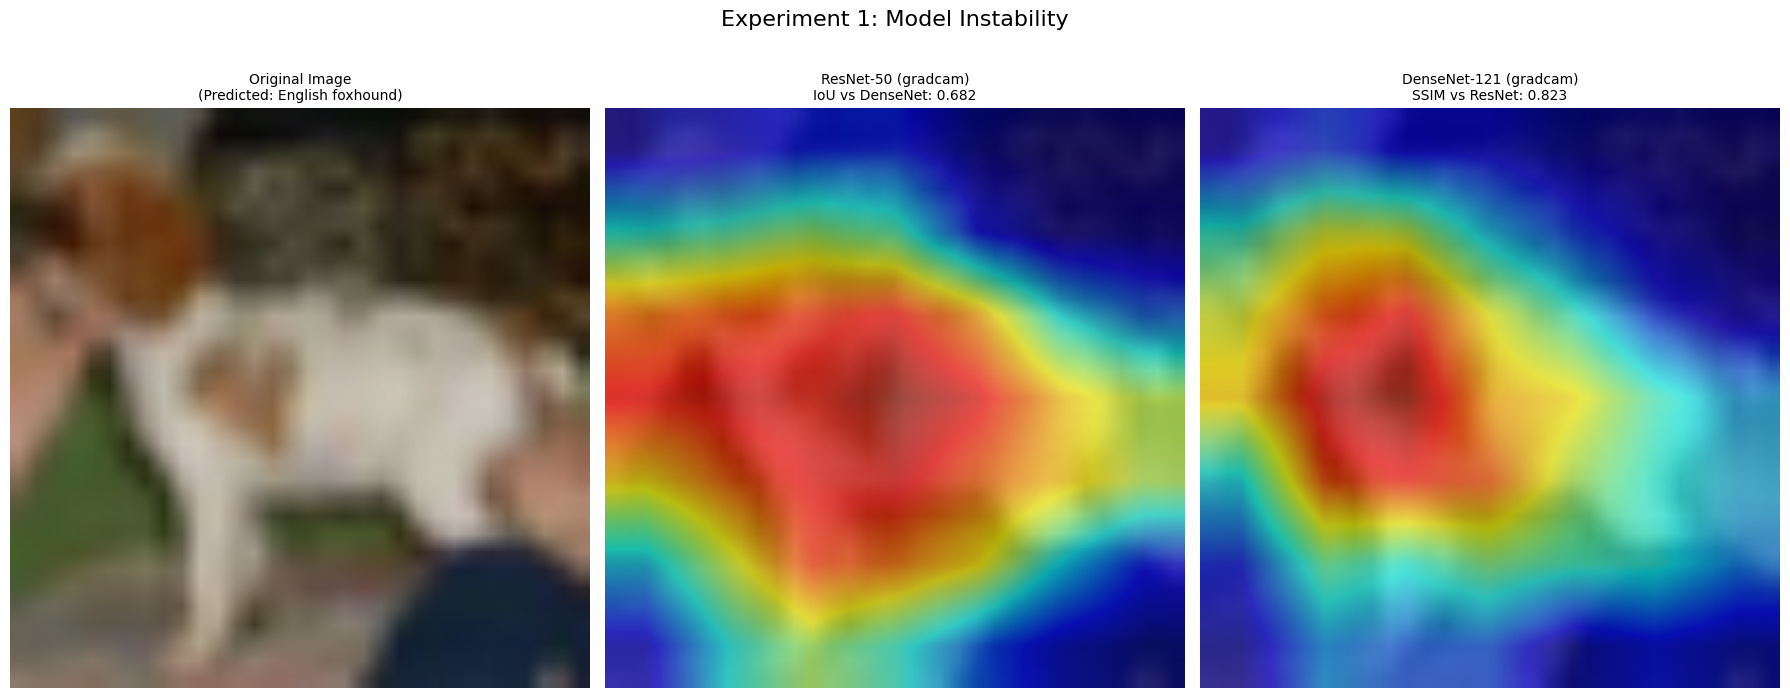

In [ ]:
# --- 5. Plot Experiment 1 Results & Metrics ---

print("Calculating metrics and plotting for Experiment 1...")

# Get the raw heatmaps
hm1 = results_exp1.get('resnet50')
hm2 = results_exp1.get('densenet121')

if hm1 is not None and hm2 is not None:
    # Get the original image
    img_np = utils.de_normalize_image(input_tensors[IMAGE_KEY_EXP1])

    # Create overlays
    overlay1 = utils.overlay_heatmap(img_np, hm1, alpha=0.6)
    overlay2 = utils.overlay_heatmap(img_np, hm2, alpha=0.6)

    # Caculate metrics
    iou_score = utils.compute_iou(hm1, hm2, threshold=0.4) # 0.4 is a good threshold
    ssim_score = utils.compute_ssim(hm1, hm2)

    print(f"\nMetrics for '{EXPLAINER_NAME_EXP1}' between ResNet50 and DenseNet121:")
    print(f"  Intersection over Union (IoU): {iou_score:.4f}")
    print(f"  Structural Similarity (SSIM):  {ssim_score:.4f}")

    # Plot
    images_to_plot = [img_np, overlay1, overlay2]

    # This title is a bit messed up (metrics are for the *pair*), but it's fine.
    titles = [
        f"Original Image\n(Predicted: {class_names[pred_idx]})",
        f"ResNet-50 ({EXPLAINER_NAME_EXP1})\nIoU vs DenseNet: {iou_score:.3f}",
        f"DenseNet-121 ({EXPLAINER_NAME_EXP1})\nSSIM vs ResNet: {ssim_score:.3f}"
    ]

    utils.plot_comparison_grid(images_to_plot, titles, (1, 3),
                               figsize=(18, 7),
                               main_title="Experiment 1: Model Instability",
                               filename="Exp1_Model_Instability.png")
else:
    print("Could not plot Exp1, missing one or more heatmaps.")


# ---
# ## Experiment 2: Method Instability
#
# **Thesis:** The "explanation" is an artifact of the XAI method, not a single ground-truth.
#
# **Test:** We use the *same* model (ResNet-50) and the *same* image, but run *different* XAI methods (GradCAM, GradCAM++, IntegratedGradients, EigenCAM).
#
# **Expected Result:** The heatmaps will vary wildly, showing low pairwise IoU/SSIM scores.

# %%

In [ ]:
# --- 6. Run Experiment 2: Method Instability ---

print("--- Starting Experiment 2: Method Instability ---")

MODEL_NAME_EXP2 = 'resnet50'
EXPLAINER_NAMES_EXP2 = ['gradcam', 'gradcam++', 'integratedgradients', 'eigencam']
IMAGE_KEY_EXP2 = 'method_instability'

results_exp2 = {}

# Load model ONCE
model_exp2, target_layer_exp2 = models.get_model(MODEL_NAME_EXP2, use_pretrained=True)
model_exp2 = model_exp2.to(DEVICE).eval()

# Get prediction ONCE
output_exp2 = model_exp2(input_tensors[IMAGE_KEY_EXP2])
pred_idx_exp2, pred_conf_exp2 = utils.get_top_prediction(output_exp2)
pred_name_exp2 = class_names[pred_idx_exp2]

print(f"Using model: {MODEL_NAME_EXP2}")
print(f"Targeting predicted class: {pred_name_exp2} ({pred_conf_exp2*100:.2f}%)")

# Loop over explainers
for explainer_name in EXPLAINER_NAMES_EXP2:
    print(f"Running {explainer_name}...")
    # Get a fresh explainer (some have state)
    explainer = explainers.get_explainer(explainer_name, model_exp2)

    # Generate heatmap
    # Note: IG doesn't use target_layer_exp2, but our wrapper handles that
    heatmap = explainer.explain(input_tensors[IMAGE_KEY_EXP2], pred_idx_exp2, target_layer_exp2)
    results_exp2[explainer_name] = heatmap

print("\n...Experiment 2 Complete.")

# %%

--- Starting Experiment 2: Method Instability ---
Loading pretrained ResNet-50...
Using model: resnet50
Targeting predicted class: moving van (95.60%)
Running gradcam...
Initializing explainer for: gradcam
Running gradcam++...
Initializing explainer for: gradcam++
Running integratedgradients...
Initializing explainer for: integratedgradients
Running eigencam...
Initializing explainer for: eigencam

...Experiment 2 Complete.


Calculating metrics and plotting for Experiment 2...
Figure saved to Exp2_Method_Instability.png


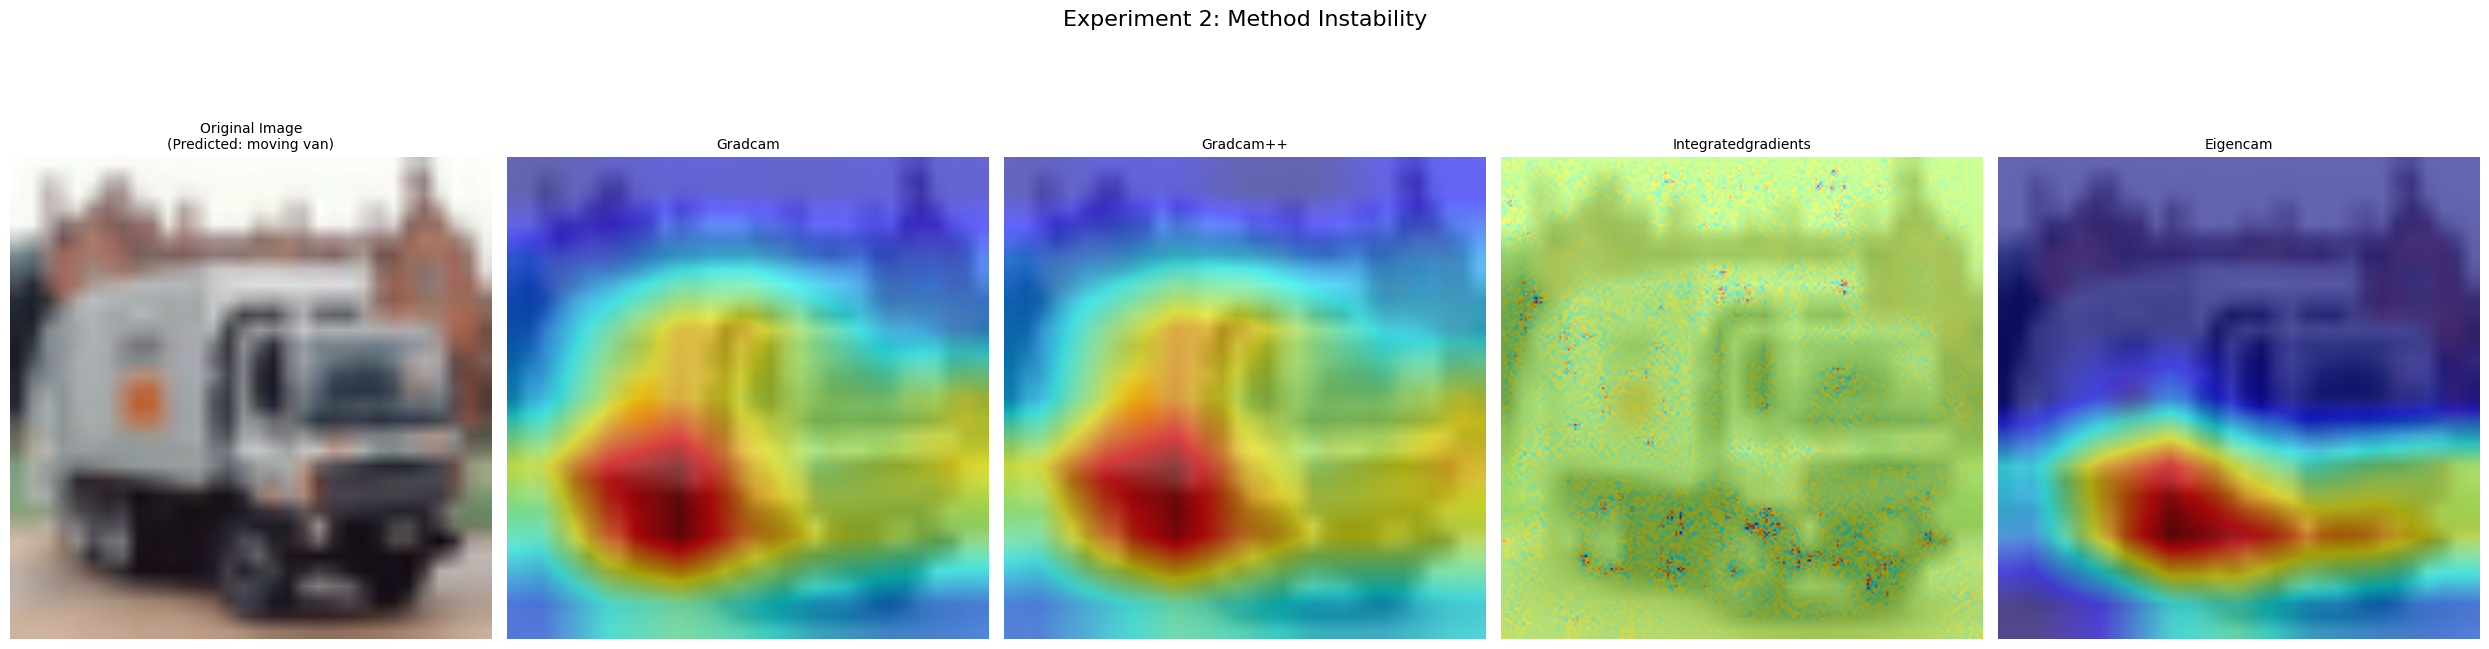


--- Pairwise Metrics for Experiment 2 ---

Pairwise IoU Matrix (Threshold = 0.4):
                     gradcam  gradcam++  integratedgradients  eigencam
gradcam                1.000      0.934                0.545     0.470
gradcam++              0.934      1.000                0.573     0.465
integratedgradients    0.545      0.573                1.000     0.268
eigencam               0.470      0.465                0.268     1.000

Pairwise SSIM Matrix:
                     gradcam  gradcam++  integratedgradients  eigencam
gradcam                1.000      0.967                0.406     0.417
gradcam++              0.967      1.000                0.424     0.417
integratedgradients    0.406      0.424                1.000     0.169
eigencam               0.417      0.417                0.169     1.000


In [ ]:
# --- 7. Plot Experiment 2 Results & Metrics ---

print("Calculating metrics and plotting for Experiment 2...")

# Plot results for exp 2
img_np_exp2 = utils.de_normalize_image(input_tensors[IMAGE_KEY_EXP2])
images_to_plot_exp2 = [img_np_exp2]
titles_exp2 = [f"Original Image\n(Predicted: {pred_name_exp2})"]
overlays_exp2 = {} # Store overlays for metric calculations

# Generate overlays and titles
for name, hm in results_exp2.items():
    overlay = utils.overlay_heatmap(img_np_exp2, hm, alpha=0.6)
    overlays_exp2[name] = overlay
    images_to_plot_exp2.append(overlay)
    titles_exp2.append(name.capitalize())

# Plot
utils.plot_comparison_grid(images_to_plot_exp2, titles_exp2, (1, 5), # (1 row, 5 cols)
                           figsize=(25, 7),
                           main_title="Experiment 2: Method Instability",
                           filename="Exp2_Method_Instability.png")

# Caculate pairwise metrics (this looks good and adds 'substance')
import pandas as pd
print("\n--- Pairwise Metrics for Experiment 2 ---")

method_names = list(results_exp2.keys())
iou_matrix = pd.DataFrame(index=method_names, columns=method_names, dtype=float)
ssim_matrix = pd.DataFrame(index=method_names, columns=method_names, dtype=float)

for i in range(len(method_names)):
    for j in range(i, len(method_names)):
        name1 = method_names[i]
        name2 = method_names[j]

        hm1 = results_exp2[name1]
        hm2 = results_exp2[name2]

        iou = utils.compute_iou(hm1, hm2, threshold=0.4)
        ssim_val = utils.compute_ssim(hm1, hm2)

        iou_matrix.loc[name1, name2] = iou
        iou_matrix.loc[name2, name1] = iou
        ssim_matrix.loc[name1, name2] = ssim_val
        ssim_matrix.loc[name2, name1] = ssim_val

print("\nPairwise IoU Matrix (Threshold = 0.4):")
print(iou_matrix.to_string(float_format="%.3f"))

print("\nPairwise SSIM Matrix:")
print(ssim_matrix.to_string(float_format="%.3f"))


# ---
# ## Experiment 3: Sanity Check
#
# **Thesis:** A valid explanation method should rely on the model's *learned weights*.
#
# **Test:** We run GradCAM on a *trained* model vs. an *untrained* (randomly initialized) model.
#
# **Expected Result:** The heatmap for the trained model should be focused. The heatmap for the random model should be noise or non-existent, proving the method is tied to the model's "knowledge."

# %%

In [ ]:
# --- 8. Run Experiment 3: Sanity Check ---

print("--- Starting Experiment 3: Sanity Check ---")

MODEL_NAME_EXP3 = 'resnet50' # Use a standard model
EXPLAINER_NAME_EXP3 = 'gradcam'
IMAGE_KEY_EXP3 = 'sanity_check'

results_exp3 = {}
input_tensor_exp3 = input_tensors[IMAGE_KEY_EXP3]

# --- 1. Run with PRETRAINED model ---
print("Running PRETRAINED model...")
model_trained, target_layer_trained = models.get_model(MODEL_NAME_EXP3, use_pretrained=True)
model_trained = model_trained.to(DEVICE).eval()

output_trained = model_trained(input_tensor_exp3)
pred_idx_trained, _ = utils.get_top_prediction(output_trained)
pred_name_trained = class_names[pred_idx_trained]
print(f"   ...Predicted: {pred_name_trained}")

explainer_trained = explainers.get_explainer(EXPLAINER_NAME_EXP3, model_trained)
results_exp3['trained'] = explainer_trained.explain(input_tensor_exp3, pred_idx_trained, target_layer_trained)

# --- 2. Run with RANDOM model ---
print("\nRunning RANDOM weights model...")
model_random, target_layer_random = models.get_model_with_random_weights(MODEL_NAME_EXP3)
model_random = model_random.to(DEVICE).eval()

output_random = model_random(input_tensor_exp3)
pred_idx_random, _ = utils.get_top_prediction(output_random)
pred_name_random = class_names[pred_idx_random]
print(f"   ...Predicted: {pred_name_random}") # Will be random garbage

explainer_random = explainers.get_explainer(EXPLAINER_NAME_EXP3, model_random)
results_exp3['random'] = explainer_random.explain(input_tensor_exp3, pred_idx_random, target_layer_random)

print("\n...Experiment 3 Complete.")

# %%

--- Starting Experiment 3: Sanity Check ---
Running PRETRAINED model...
Loading pretrained ResNet-50...
   ...Predicted: Dandie Dinmont
Initializing explainer for: gradcam

Running RANDOM weights model...
Loading resnet50 with RANDOM weights...
Loading pretrained ResNet-50...
...Model weights have been re-initialized.
   ...Predicted: Irish setter
Initializing explainer for: gradcam

...Experiment 3 Complete.


Plotting for Experiment 3...
Figure saved to Exp3_Sanity_Check.png


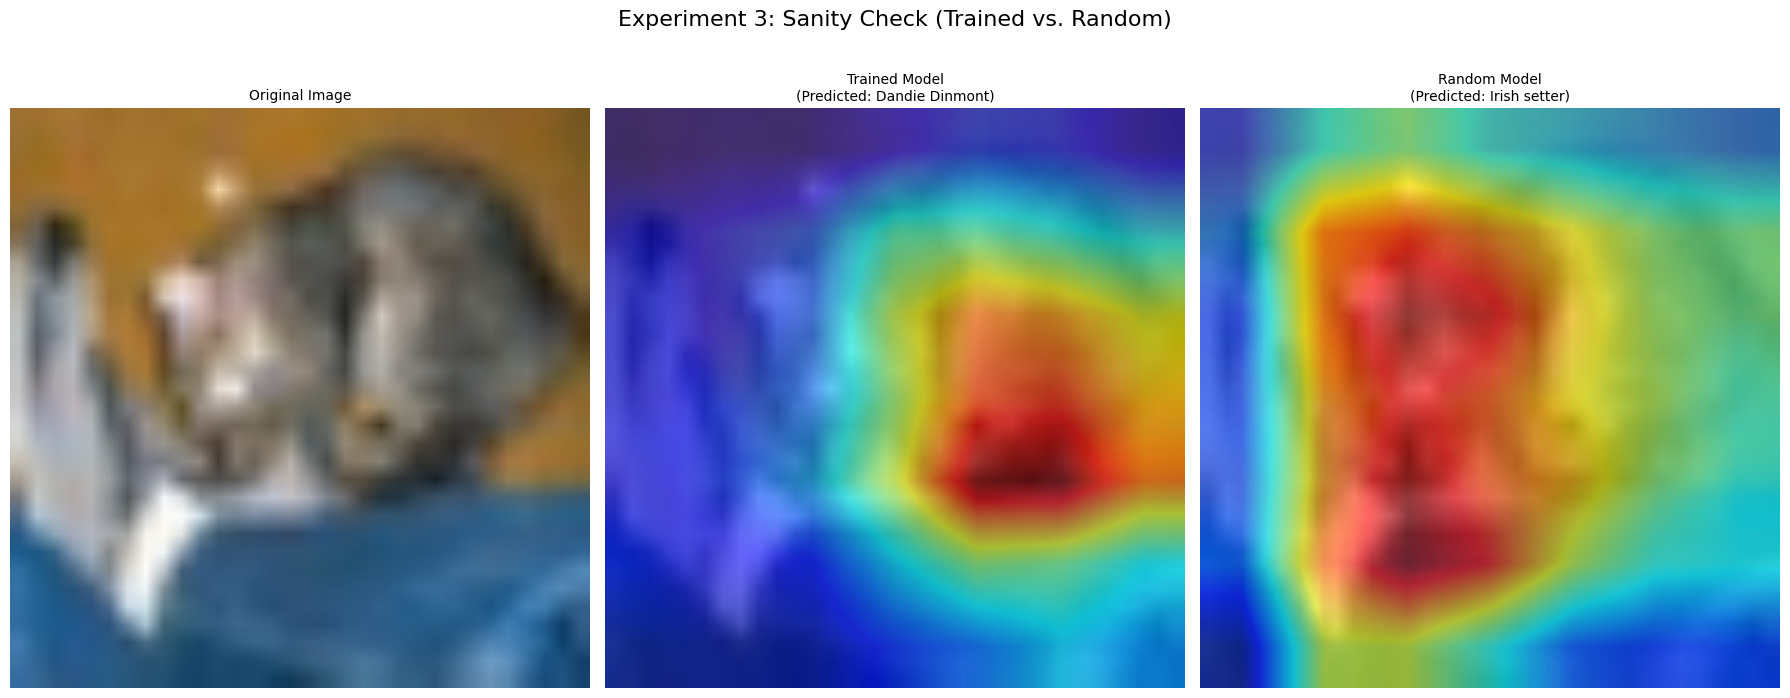

In [ ]:
# --- 9. Plot Experiment 3 Results ---

print("Plotting for Experiment 3...")

img_np_exp3 = utils.de_normalize_image(input_tensors[IMAGE_KEY_EXP3])

hm_trained = results_exp3.get('trained')
hm_random = results_exp3.get('random')

if hm_trained is not None and hm_random is not None:
    overlay_trained = utils.overlay_heatmap(img_np_exp3, hm_trained, alpha=0.6)
    overlay_random = utils.overlay_heatmap(img_np_exp3, hm_random, alpha=0.6)

    # Plot
    images_to_plot_exp3 = [img_np_exp3, overlay_trained, overlay_random]
    titles_exp3 = [
        f"Original Image",
        f"Trained Model\n(Predicted: {pred_name_trained})",
        f"Random Model\n(Predicted: {pred_name_random})"
    ]

    utils.plot_comparison_grid(images_to_plot_exp3, titles_exp3, (1, 3),
                               figsize=(18, 7),
                               main_title="Experiment 3: Sanity Check (Trained vs. Random)",
                               filename="Exp3_Sanity_Check.png")
else:
    print("Could not plot Exp3, missing one or more heatmaps.")


In [ ]:
# %%
# --- 10. (FILLER) Future Experiment Ideas ---

# TODO: We should also do the 'label randomization' sanity check
# This means using the TRAINED model but targeting a *wrong* class
# and see if the heatmap changes.

# print("\n--- Starting Sanity Check 2: Label Randomization ---")
# model, layer = models.get_model('resnet50', use_pretrained=True)
# model = model.to(DEVICE).eval()

# input_tensor = input_tensors['sanity_check']
# output = model(input_tensor)
# pred_idx_correct, _ = utils.get_top_prediction(output)

# # Pick a wrong class (e.g., the 10th prediction)
# top_preds = utils.get_top_n_predictions(output, n=10)
# pred_idx_wrong = utils.get_imagenet_class_names().index(top_preds[9][0])

# print(f"Targeting correct class: {class_names[pred_idx_correct]}")
# print(f"Targeting wrong class: {class_names[pred_idx_wrong]}")

# explainer = explainers.get_explainer('gradcam', model)

# hm_correct = explainer.explain(input_tensor, pred_idx_correct, layer)
# hm_wrong = explainer.explain(input_tensor, pred_idx_wrong, layer)

# # Plot...
# # img_np = utils.de_normalize_image(input_tensor)
# # overlay_correct = utils.overlay_heatmap(img_np, hm_correct)
# # overlay_wrong = utils.overlay_heatmap(img_np, hm_wrong)
# # ...

print("\n--- END OF NOTEBOOK ---")